<a href="https://colab.research.google.com/github/DrSubbiah/1.Bayesian-Inference/blob/master/10_NormalMean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="darkblue">Numeric / Metric Data Model

In [ ]:
import numpy as np
import pandas as pd
import statistics as stat
import scipy
import pystan

In [ ]:
#For plots
import arviz as az
import matplotlib.pyplot as plt

#<font color="darkblue"> Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Data Sets/BirthWt.csv"
brtwt_da = pd.read_csv(path)

In [ ]:
brtwt_da.head()

,id,matage,ht,gestwks,sex,bweight,matagegp,gestcat
0,1,33,no,37.740002,female,2410,2,2
1,2,34,no,39.150002,female,2977,2,2
2,3,34,no,35.720001,female,2100,2,1
3,4,30,no,39.290001,male,3270,2,2
4,5,35,no,38.380001,female,2620,3,2


In [ ]:
print(brtwt_da.dtypes)

# <font color="darkblue"> Model 1. Normal Model without Predictor

## Response Variable: *bweight*



# Input - data and values for prior parameters

In [ ]:
brtwt_data = {
             'n': len(brtwt_da),
             'y': brtwt_da['bweight'],
             'a':3000,
             'b':10,
             'g1':3,
             'g2':1,
            }
print(brtwt_data)

# STAN Code

In [ ]:
brtwt_code1 = """
data {
    real a;
    real<lower=0> b;
    real<lower=0> g1;
    real<lower=0> g2;
    int<lower=0> n;
    real y[n];
}

parameters {
    real mu;
     real<lower=0> sig;
}

transformed parameters {
  real<lower=0> tau;
  tau=(1/sig)^2;
}

model {
      y ~ normal(mu, sig);
      mu ~ normal(a, b);
      tau ~ gamma(g1,g2);
}
"""
# posterior
posterior1 = pystan.StanModel(model_code=brtwt_code1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7724acc493ed1d41d8cb912abca05633 NOW.


#Model Fitting - Sampling

In [ ]:
fit_model1= posterior1.sampling(data=brtwt_data,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

# <font color="darkorange">Pystan Summary - Information about Model and Metrics

In [ ]:
summ_mod1=az.summary(fit_model1,var_names=['~mu','~tau'],round_to=3,hdi_prob=0.95)
summ_mod1

#<font color="darkorange"> MCMC convergence Diagnostics - Plots

In [ ]:
az.plot_trace(fit_model1,compact=False, legend=True)
plt.show()

# <font color="darkorange"> Condensed Summary Report

In [ ]:
summ_mod1=az.summary(fit_model1,round_to=3,hdi_prob=0.95)
summ_mod1

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,120.399,10.087,100.719,139.891,0.083,0.059,14640.532,13984.426,1.0
sig,3075.598,87.227,2903.240,3246.087,0.735,0.521,14309.337,12594.598,1.0
tau,0.000,0.000,0.000,0.000,0.000,0.000,14309.337,12594.598,1.0


# <font color="darkorange">Histogram, Density plot from the posterior for the QoI

In [ ]:
# QoI "mu"
az.plot_dist(fit_model1['mu'],quantiles=[.25, .5, .75],kind="hist",figsize=(20, 6))
plt.show()

In [ ]:
#QoI "theta=sig"
az.plot_dist(fit_model1['sig'],quantiles=[0.25, 0.5, 0.75],kind="kde",figsize=(20, 6))
plt.show()

# Normal Model with One Predictor

In [ ]:
brtwt_code2 = """
data {
    real a;
    real<lower=0> b;
    real<lower=0> g1;
    real<lower=0> g2;
    int<lower=0> n;
    real y[n];
    vector[n] x;
}

parameters {
    real b0;
    real b1;
    real<lower=0> sig;
}

transformed parameters {
  vector[n] mu;
  real<lower=0> tau;

  mu=b0+b1*x;
  tau=(1/sig)^2;
}

model {
      y ~ normal(mu, sig);
      b0 ~ normal(a, b);
      b1 ~ normal(a, b);
      tau ~ gamma(g1,g2);
}
"""
# posterior
posterior2 = pystan.StanModel(model_code=brtwt_code2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ccd4717251357f33e02721b53ac35d9e NOW.


In [ ]:
brtwt_data2 = {
             'n': len(brtwt_da),
             'x': brtwt_da['gestwks'],
             'y': brtwt_da['bweight'],
             'a':0,
             'b':10,
             'g1':3,
             'g2':1,
            }
print(brtwt_data2)

In [ ]:
fit_model2= posterior2.sampling(data=brtwt_data2,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

In [ ]:
summ_mod2=az.summary(fit_model2,var_names=['~mu','~tau'],round_to=3,hdi_prob=0.95)
summ_mod2

In [ ]:
az.plot_trace(fit_model2,var_names=['~mu'], compact=False,legend=True)
plt.show()

In [ ]:
# QoI "b0"
az.plot_dist(fit_model2['b0'],quantiles=[.25, .5, .75],kind="hist",figsize=(20, 6))
plt.show()

In [ ]:
#QoI "theta=b1"
az.plot_dist(fit_model2['b1'],quantiles=[0.25, 0.5, 0.75],kind="kde",figsize=(20, 6))
plt.show()

# Normal Model with one predictor

## Prior for intercept is different

In [ ]:
brtwt_code3 = """
data {
    real a_i;
    real<lower=0> b_i;
    real a_p1;
    real<lower=0> b_p1;
    real<lower=0> g1;
    real<lower=0> g2;
    int<lower=0> n;
    real y[n];
    vector[n] x;
}

parameters {
    real b0;
    real b1;
    real<lower=0> sig;
}

transformed parameters {
  vector[n] mu;
  real<lower=0> tau;
  mu=b0+b1*x;
  tau=(1/sig)^2;
}

model {
      y ~ normal(mu, sig);
      b0 ~ normal(a_i, b_i);
      b1 ~ normal(a_p1, b_p1);
      tau ~ gamma(g1,g2);
}
"""
# posterior
posterior3 = pystan.StanModel(model_code=brtwt_code3)

In [ ]:
brtwt_data3 = {
             'n': len(brtwt_da),
             'x': brtwt_da['gestwks'],
             'y': brtwt_da['bweight'],
             'a_i':0,
             'b_i':10,
             'a_p1':500,
             'b_p1':10,
             'g1':3,
             'g2':1,
            }
print(brtwt_data3)

In [ ]:
fit_model3= posterior3.sampling(data=brtwt_data3,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

In [ ]:
summ_mod3=az.summary(fit_model3,var_names=['~mu','~tau'],round_to=3,hdi_prob=0.95)
summ_mod3

In [ ]:
az.plot_trace(fit_model3,var_names=['~mu'], compact=False,legend=True)
plt.show()

In [ ]:
# QoI "b0"
az.plot_dist(fit_model3['b0'],quantiles=[.25, .5, .75],kind="hist",figsize=(20, 6))
plt.show()

In [ ]:
#QoI "theta=b1"
az.plot_dist(fit_model3['b1'],quantiles=[0.25, 0.5, 0.75],kind="kde",figsize=(20, 6))
plt.show()

# Normal Model with one Binary predictor


In [ ]:
brtwt_code4 = """
data {
    real a_i;
    real<lower=0> b_i;
    real a_p1;
    real<lower=0> b_p1;
    real<lower=0> g1;
    real<lower=0> g2;
    int<lower=0> n;
    real y[n];
    vector[n] x;
}

parameters {
    real b0;
    real b1;
    real<lower=0> sig;
}

transformed parameters {
  vector[n] mu;
  real<lower=0> tau;
  mu=b0+b1*x;
  tau=(1/sig)^2;
}

model {
      y ~ normal(mu, sig);
      b0 ~ normal(a_i, b_i);
      b1 ~ normal(a_p1, b_p1);
      tau ~ gamma(g1,g2);
}
"""
# posterior
posterior4 = pystan.StanModel(model_code=brtwt_code4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_26ecf12753bb02faa64b0009a4a8e8ff NOW.


In [ ]:
brtwt_da=brtwt_da.assign(sex_c=lambda x:x['sex'].apply(lambda y: 1 if y=="male" else 0))
#brtwt_da['sex_c'] = brtwt_da['sex_c'].astype('category')

In [ ]:
dumm_sex=pd.get_dummies(brtwt_da['sex'],prefix='sex_', columns=['sex'])
brtwt_da = pd.concat([brtwt_da, dumm_sex], axis=1)

In [ ]:
brtwt_da.dtypes

In [ ]:
brtwt_da.head()

In [ ]:
brtwt_data4 = {
             'n': len(brtwt_da),
             'x': brtwt_da['sex_c'],
             'y': brtwt_da['bweight'],
             'a_i':3000,
             'b_i':100,
             'a_p1':200,
             'b_p1':10,
             'g1':3,
             'g2':1,
            }
print(brtwt_data4)

In [ ]:
brtwt_data41 = {
             'n': len(brtwt_da),
             'x': brtwt_da['sex__male'],
             'y': brtwt_da['bweight'],
             'a_i':3000,
             'b_i':100,
             'a_p1':0,
             'b_p1':100,
             'g1':3,
             'g2':1,
            }
print(brtwt_data41)

In [ ]:
fit_model4= posterior4.sampling(data=brtwt_data41,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

In [ ]:
summ_mod4=az.summary(fit_model4,var_names=['~mu','~tau'],round_to=3,hdi_prob=0.95)
summ_mod4

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,3055.275,32.382,2991.135,3117.985,0.300,0.212,11657.126,15055.938,1.0
b1,138.049,44.227,48.704,221.484,0.414,0.292,11435.541,13463.175,1.0
sig,647.027,17.968,612.432,682.779,0.138,0.098,16925.593,15888.271,1.0


In [ ]:
az.plot_trace(fit_model4,var_names=['~mu','~tau'], compact=False,legend=True)
plt.show()

In [ ]:
# QoI "b0"
az.plot_dist(fit_model4['b0'],quantiles=[.25, .5, .75],kind="hist",figsize=(20, 6))
plt.show()

In [ ]:
#QoI "theta=b1"
az.plot_dist(fit_model4['b1'],quantiles=[0.25, 0.5, 0.75],kind="kde",figsize=(20, 6))
plt.show()

# Polychotomous Predictor

## <font color="red"> Question:

In [ ]:
dumm_matagegp=pd.get_dummies(brtwt_da['matagegp'],prefix='matagegp_', columns=['matagegp'],drop_first=True)
brtwt_da = pd.concat([brtwt_da, dumm_matagegp], axis=1)

In [ ]:
brtwt_code5 = """
data {
    real a_i;
    real<lower=0> b_i;
    real a_p2;
    real<lower=0> b_p2;
    real a_p3;
    real<lower=0> b_p3;
    real a_p4;
    real<lower=0> b_p4;
    real<lower=0> g1;
    real<lower=0> g2;
    int<lower=0> n;
    real y[n];
    vector[n] x2;
    vector[n] x3;
    vector[n] x4;
}

parameters {
    real b0;
    real b2;
    real b3;
    real b4;
    real<lower=0> sig;
}

transformed parameters {
  vector[n] mu;
  real<lower=0> tau;
  mu=b0+b2*x2+b3*x3+b4*x4;
  tau=(1/sig)^2;
}

model {
      y ~ normal(mu, sig);
      b0 ~ normal(a_i, b_i);
      b2 ~ normal(a_p2, b_p2);
      b3 ~ normal(a_p3, b_p3);
      b4 ~ normal(a_p4, b_p4);
      tau ~ gamma(g1,g2);
}
"""
# posterior
posterior5 = pystan.StanModel(model_code=brtwt_code5)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2df0622cf2352b2fafda6deca6943f70 NOW.


In [ ]:
brtwt_data5 = {
             'n': len(brtwt_da),
             'x2': brtwt_da['matagegp__2'],
             'x3': brtwt_da['matagegp__3'],
             'x4': brtwt_da['matagegp__4'],
             'y': brtwt_da['bweight'],
             'a_i':3000,
             'b_i':100,
             'a_p2':0,
             'b_p2':100,
             'a_p3':0,
             'b_p3':100,
             'a_p4':0,
             'b_p4':100,
             'g1':3,
             'g2':1,
            }
print(brtwt_data5)

In [ ]:
fit_model5= posterior5.sampling(data=brtwt_data5,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

In [ ]:
summ_mod5=az.summary(fit_model5,var_names=['~mu','~tau'],round_to=3,hdi_prob=0.95)
summ_mod5

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,3094.572,43.368,3010.449,3180.227,0.420,0.297,10691.602,14406.843,1.0
b2,37.159,53.405,-69.150,141.484,0.487,0.347,12016.480,14773.385,1.0
b3,33.061,53.257,-74.853,135.003,0.483,0.341,12185.523,15916.541,1.0
b4,8.460,74.977,-136.412,156.273,0.594,0.460,15936.955,18081.496,1.0
sig,652.841,18.225,617.961,689.399,0.138,0.097,17607.607,16030.709,1.0


In [ ]:
az.plot_trace(fit_model5,var_names=['~mu','~tau'], compact=False,legend=True)
plt.show()

In [ ]:
# QoI "b0"
az.plot_dist(fit_model4['b0'],quantiles=[.25, .5, .75],kind="hist",figsize=(20, 6))
plt.show()

In [ ]:
#QoI "theta=b1"
az.plot_dist(fit_model5['b2'],quantiles=[0.25, 0.5, 0.75],kind="kde",figsize=(20, 6))
plt.show()

In [ ]:
priorpred="""
data {
int n; // number of trials
int p; // number of simulated patients
}
parameters {
real<lower=0,upper=1> theta;
}
model {
// prior
theta ~ beta(2,2);
}
generated quantities {
int<lower=0, upper=n> y_sim[p];
// prior predictive distributions for p patients:
for(i in 1:p) {
y_sim[i] = binomial_rng(n,theta);
}
}
"""
pri_pred = pystan.StanModel(model_code=priorpred)

In [ ]:
prpc_data={'n':10,'p':5}
prpc_data

{'n': 10, 'p': 5}

In [ ]:
fit_model_prPC= pri_pred.sampling(data=prpc_data,
                  iter=10000,
                  chains=4,
                  seed=1,
                 warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

In [ ]:
summ_mod_PrPC=az.summary(fit_model_prPC,round_to=3,hdi_prob=0.95)
summ_mod_PrPC

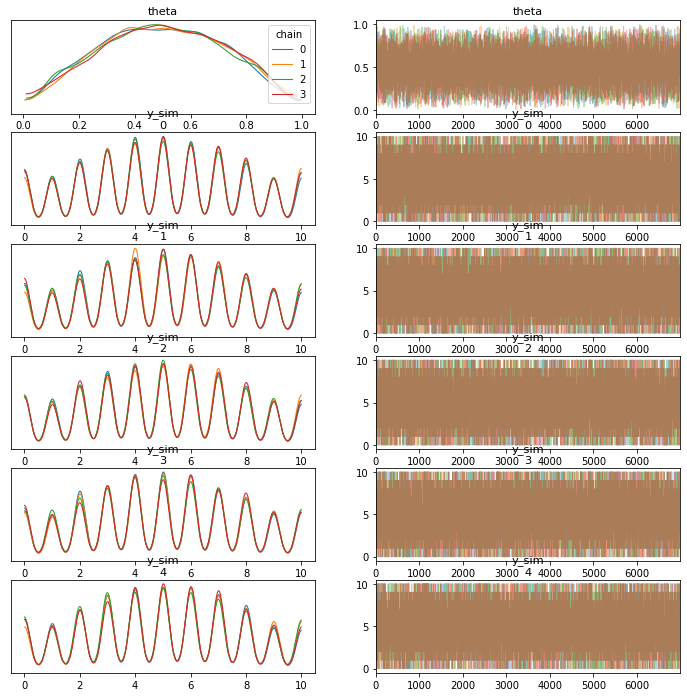

In [ ]:
az.plot_trace(fit_model_prPC, compact=False,legend=True)
plt.show()

In [ ]:
data_prpc = az.from_pystan(posterior=fit_model_prPC)
data_prpc

Inference data with groups:
	> posterior
	> sample_stats

In [ ]:
#data_prpc.posterior.y_sim
az.plot_dist(data_prpc.posterior.y_sim,kind="hist",figsize=(20,10))

In [ ]:
pp=fit_model_prPC.extract()

In [ ]:
pp.dim

AttributeError: ignored